<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

---

# TP1 Instructions


The goal of this TP is to work on a mortality prediction problem and to participate into the "To be or not to be?" challenge.

A fresh instance of the challenge can be found here: https://competitions.codalab.org/competitions/27605


<b><font size="5">Outline</font></b><br/><br/>
&emsp;&emsp;&emsp; I) <a href="#data"> Load data</a><br/>
&emsp;&emsp;&emsp; II) <a href="#exploratory"> Exploratory analysis/Visualization </a><br/>
&emsp;&emsp;&emsp; III) <a href="#preprocessing"> Preprocessing </a><br/>
&emsp;&emsp;&emsp; IV) <a href="#processing"> Processing </a><br/>
&emsp;&emsp;&emsp; V) <a href="#model"> Predictive model </a><br/>
&emsp;&emsp;&emsp; VI) <a href="#save"> Save predictions </a><br/>

# Codalab username and group member:
Mohamed Salem MESSOUD : mdsalem17  
Phan Anh VU : phanav

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import time
from zipfile import ZipFile

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import numpy as np
import seaborn as sns

import sklearn
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    plot_confusion_matrix
)

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import os
from pathlib import Path

from IPython.display import display
from pprint import pprint

### Question 1: Briefly explain the task.

This is a binary classification of tabular data.  
From information about patients, we need to predict whether the patients will die during their stay in the hospital.  
A target value of 0 means survival, and 1 means death.

### Question 2: What is the metric used in the challenge?

Balanced accuracy: average of accuracy for each class  

<table>
    <tr>
        <td>
            <img src="https://statisticaloddsandends.files.wordpress.com/2020/01/metrics1.png?w=600&h=434" width="250">
        </td>
        <td>
            <img src="https://statisticaloddsandends.files.wordpress.com/2020/01/metrics2.png?w=768&h=352" width="450">
        </td>
    </tr>
</table>
    
$$ 
\texttt{Recall = Sensitivity = True Positive Rate} \\
= \frac{True Positive}{True Positive + False Negative} = \frac{True Positive}{All Actual Positive}
\\
$$

$$
\texttt{Specificity = True Negative Rate = 1- False Positive Rate} \\
= \frac{True Negative}{True Negative + False Positive} = \frac{True Negative}{All Actual Negative}
\\
$$   

$$
\texttt{balanced-accuracy} = \frac 1 2 (\texttt{True Positive Rate} + \texttt{True Negative Rate})
= \frac{1}{2}\left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP}\right )
\\
$$

Reference:  
https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score  
https://mvpa.blogspot.com/2015/12/balanced-accuracy-what-and-why.html  


Example:  
https://statisticaloddsandends.wordpress.com/2020/01/23/what-is-balanced-accuracy/  


## <a id="data"> I) Load data</a>  

In [2]:
features = pd.read_csv(
    "public_data/mimic_synthetic_feat.name", header=None
).values.flatten()
labels = pd.read_csv(
    "public_data/mimic_synthetic_label.name", header=None
).values.flatten()
X = pd.read_csv(
    "public_data/mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)
y = pd.Series(
    pd.read_csv(
        "public_data/mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [3]:
print(X.shape)
display(X.sample(5))

(79999, 341)


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
40474,31499,182790,2145-05-22_01:47:00,2103-09-22_13:11:00,Private,ENGL,CATHOLIC,MARRIED,WHITE,M,...,0,0,0,0,0,1.0,0,0,0,0
20848,46532,182326,2143-05-10_17:30:00,2158-08-07_14:55:00,Medicare,ENGL,JEWISH,MARRIED,WHITE,F,...,0,0,0,0,0,0.0,0,0,1,0
71135,69673,123572,2180-08-04_19:16:00,2144-07-14_15:00:00,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,M,...,0,0,0,0,0,0.0,1,0,0,0
22227,97933,145563,2166-03-22_18:33:00,2132-01-28_17:02:00,Private,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,...,0,0,0,0,0,0.0,1,0,0,0
23491,53591,105164,2197-03-10_05:56:00,2170-04-06_18:20:00,Medicare,ENGL,OTHER,DIVORCED,WHITE,F,...,0,0,0,0,0,0.0,0,0,0,0


In [4]:
print(y.shape)
display(y.sample(5))
display(y.value_counts())

(79999,)


14219    0
23582    0
1556     0
18560    0
5138     0
dtype: int64

0    77202
1     2797
dtype: int64

This is the **training set**. This means that have access to the labels and you can use it in anyway you want to prepare your model.

Later on, you'll make your model draws predictions from the **testing set** in order to upload them on Codalab and get a score on unseen labels.

In [5]:
# Load testing set
X_test = pd.read_csv(
    "public_data/mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

In [6]:
print(X_test.shape)
display(X_test.sample(5))

(20001, 341)


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
6385,30670,134980,2196-09-04_12:30:00,2133-04-02_12:00:00,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,...,0,0,0,0,0,1.0,0,0,0,0
19381,16905,188701,2162-05-01_20:03:00,2133-07-28_13:32:00,Medicare,ENGL,CATHOLIC,MARRIED,BLACK/CAPE_VERDEAN,M,...,0,0,0,0,0,0.0,0,0,1,0
6185,12356,172847,2148-06-22_12:21:00,2135-08-12_14:55:00,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,M,...,0,0,0,0,0,0.0,0,0,1,0
17393,18755,109025,2156-06-27_00:00:00,2167-08-15_16:00:00,Private,ENGL,CATHOLIC,MARRIED,WHITE,M,...,0,0,0,0,0,1.0,0,0,1,0
7564,56140,145017,2171-03-28_21:32:00,2150-10-06_18:11:00,Private,ENGL,OTHER,DIVORCED,ASIAN_-_ASIAN_INDIAN,M,...,0,0,0,0,0,0.0,0,0,1,0


## <a id="exploratory"> II) Exploratory analysis and Visualization</a>

#### Variable types

In [7]:
types = pd.read_csv(
    "public_data/mimic_synthetic_feat.type", header=None
).set_index(features)[0]
print(types.value_counts())

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64


### Code 1: Display the following plots:
* Bar plots of some categorical variables (e.g. "LANGUAGE", "MARITAL_STATUS")

* Show the correlation between some variables and the target variable y.

* Another plot or any exploratory analysis you can think of

In [8]:
# TODO: plot1
display(types[types == "Categorical"].index.values)

categorical_features = "ICU INSURANCE GENDER".split(" ")

array(['ADMITTIME', 'DISCHTIME', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'ICU'], dtype=object)

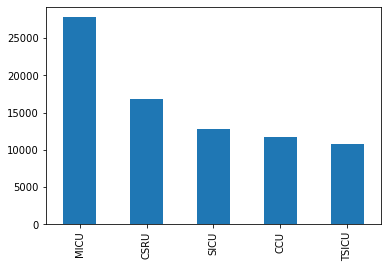

In [9]:
X["ICU"].value_counts().plot(kind="bar")

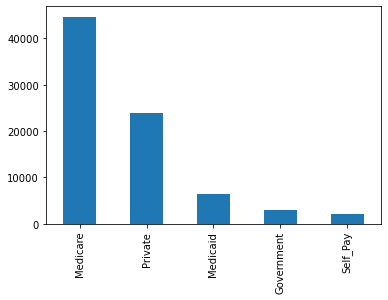

In [10]:
X["INSURANCE"].value_counts().plot(kind="bar")

## Correlation

In [11]:
Xcorr = X.corr()

In [12]:
# descending sort of correlation and remove variance of a variable with iteslf
desc_Xcorr = Xcorr.abs().unstack().sort_values(ascending = False)
desc_Xcorr = desc_Xcorr.reset_index()
desc_Xcorr = desc_Xcorr[(desc_Xcorr.iloc[:, 0] != desc_Xcorr.iloc[:, 1])]

In [13]:
desc_Xcorr[:10]

,level_0,level_1,0
159,HR_MIN_DAY1,HR_MEAN_DAY1,0.855669
160,HR_MEAN_DAY1,HR_MIN_DAY1,0.855669
161,HR_MEAN_DAY2,HR_MIN_DAY2,0.854973
162,HR_MIN_DAY2,HR_MEAN_DAY2,0.854973
163,MEAN_BP_MEAN_DAY1,DIAS_BP_MEAN_DAY1,0.827153
164,DIAS_BP_MEAN_DAY1,MEAN_BP_MEAN_DAY1,0.827153
165,HR_MEAN_DAY1,HR_MAX_DAY1,0.818055
166,HR_MAX_DAY1,HR_MEAN_DAY1,0.818055
167,TEMP_MAX_DAY2,TEMP_MEAN_DAY2,0.817794
168,TEMP_MEAN_DAY2,TEMP_MAX_DAY2,0.817794


Many numerical variables are strongly correlated.  
They seem to be typically the mean, max and min of measurements such as temperature

In [14]:
def split_yindex(xdata, ydata):
    """ Split target y into label 0 and label 1"""
    y1_idx = ydata[ydata==1].index
    y0_idx = np.setdiff1d(ydata.index, y1_idx)
    return y0_idx, y1_idx


In [15]:
def sample_data(xdata, ydata, yindex=None, yratio=4):
    """ Keep all label 1, sample from  label 0 """
    if not yindex: yindex = split_yindex(xdata, ydata)    
    sample_y0_idx = np.random.choice(yindex[0], size=len(yindex[1]) * yratio)    
    sample_idx =  np.concatenate((yindex[1], sample_y0_idx))
    return xdata.iloc[sample_idx], ydata.iloc[sample_idx]



In [16]:
xsample, ysample = sample_data(X, y)
print(xsample.shape, ysample.shape)
display(ysample.value_counts())

xtrain, xvalid, ytrain, yvalid = train_test_split(xsample, ysample, test_size=0.2)


(13985, 341) (13985,)


0    11188
1     2797
dtype: int64

In [17]:
def handle_missing(xdata):
    return xdata.fillna(xdata.median())


## <a id="preprocessing"> III) Preprocessing </a>

In [18]:
def encode_categorical(xdata):
    xencoded = xdata.copy()
    xencoded["is_male"] = (xdata["GENDER"] == "M").astype(int)
    
    onehot_cols = "ICU INSURANCE".split(" ")
    xencoded = pd.get_dummies(xencoded, columns=onehot_cols, dummy_na=True)
    
    return xencoded


In [19]:
# types[types == "Numerical"][:20]
numerical_features = types[types == "Numerical"].index.values
print(numerical_features[0:10])
print(type(numerical_features))

['SUBJECT_ID' 'HADM_ID' 'AGE' 'HR_MIN_DAY1' 'HR_MAX_DAY1' 'HR_MEAN_DAY1'
 'SYS_BP_MIN_DAY1' 'SYS_BP_MAX_DAY1' 'SYS_BP_MEAN_DAY1' 'DIAS_BP_MIN_DAY1']
<class 'numpy.ndarray'>


In [20]:
binary_features = types[types == "Binary"].index.values
binary_features = binary_features[binary_features != "GENDER"]
print(binary_features[0:10])


['AcuteMI' 'Coronathero' 'Pulmhartdx' 'Conduction' 'Dysrhythmia'
 'Cardiaarrst' 'chf;nonhp' 'AcuteCVD' 'Precereoccl' 'LateeffCVD']


In [21]:
def select_columns(xdata):
    exclude_cols = ('ADMITTIME', 'DISCHTIME', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER')
    selected_cols = np.setdiff1d(xdata.columns, exclude_cols)
    return xdata[selected_cols]


In [22]:
def preprocess(xraw):
    xencoded = encode_categorical(xraw)
    x_no_missing = handle_missing(xencoded)
    xselected = select_columns(x_no_missing)
    return xselected

xtrain_preprocess = preprocess(xtrain)
xvalid_preprocess = preprocess(xvalid)
print(xtrain_preprocess.shape, xvalid_preprocess.shape)


(11188, 345) (2797, 345)


# PCA

In [23]:
pca_model = sklearn.decomposition.PCA()
xtrain_pca = pca_model.fit_transform(xtrain_preprocess)

In [24]:
print(pca_model.explained_variance_ratio_[:30])

[5.08891112e-01 4.91096677e-01 5.86413773e-06 1.27751401e-06
 1.05714536e-06 7.92316923e-07 6.26576108e-07 4.06586555e-07
 3.43386950e-07 3.09799812e-07 2.47176374e-07 1.71839928e-07
 1.53282391e-07 1.50770210e-07 1.34697695e-07 9.57724190e-08
 7.09378732e-08 6.49155216e-08 5.53430097e-08 5.20516947e-08
 4.84342578e-08 3.85268962e-08 3.23938146e-08 2.68542714e-08
 2.34697367e-08 2.06210150e-08 1.85939030e-08 1.61230198e-08
 1.47210451e-08 1.31594871e-08]


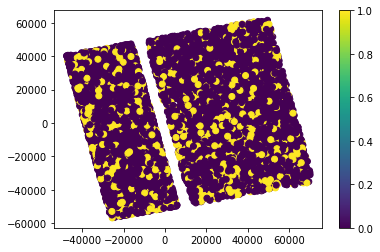

In [25]:
plt.scatter(xtrain_pca[:,0], xtrain_pca[:,1], c=ytrain)
plt.colorbar()
plt.show()

The first 2 principal components hold a large portion of variance.  
However, they are not enough to untangle the 2 label classes.

## <a id="processing"> III) Processing</a>


In [26]:
# xtrain_final = xtrain_encoded[selected_columns]
xtrain_final = xtrain_preprocess
ytrain_final = ytrain

# xvalid_final = xvalid_encoded[selected_columns]
xvalid_final = xvalid_preprocess
yvalid_final = yvalid

print(xtrain_final.shape, ytrain_final.shape)
print(xvalid_final.shape, yvalid_final.shape)

(11188, 345) (11188,)
(2797, 345) (2797,)


## <a id="model"> IV) Predictive model</a>
Train a model and assess its performance.

### Random Forest Classifier model

In [27]:
# Baseline: Random Forest
clf = RandomForestClassifier(
    n_estimators=10, class_weight="balanced",
    max_depth=5, 
)

clf.fit(xtrain_final, ytrain_final)  # training

ypred = clf.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.6511389204801139


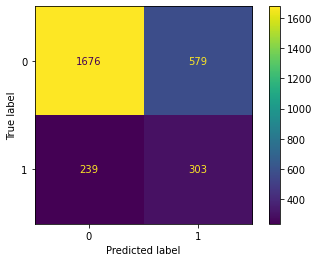

In [28]:
plot_confusion_matrix(clf, xvalid_final, yvalid_final)

## Compare result while varying number of principal components

In [29]:
n_components = np.arange(start=10, stop=300, step=10)
pca_scores = []

for n_component in n_components:
    pca_clf = RandomForestClassifier(n_estimators=10, class_weight="balanced",
        max_depth=5, 
    )

    pca_clf.fit(xtrain_pca[:, :n_component], ytrain_final)  # training

    pca_predictions = pca_clf.predict(pca_model.transform(xvalid_final)[:, :n_component])  # predictions
    pca_scores.append(balanced_accuracy_score(yvalid_final, pca_predictions))  # scoring
    


Text(0, 0.5, 'valid balanced accuracy')

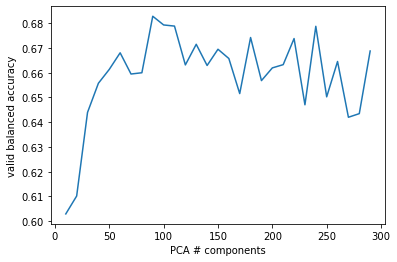

In [30]:
plt.plot(n_components, pca_scores)
plt.xlabel("PCA # components")
plt.ylabel("valid balanced accuracy")

In [31]:
best_pca_score_index = np.argmax(pca_scores)
best_pca_n_components = n_components[best_pca_score_index]
print(best_pca_score_index)
print('best n_components: ', best_pca_n_components, ' and best pca_scores: ', pca_scores[best_pca_score_index])

8
best n_components:  90  and best pca_scores:  0.6828572831182858


In [32]:
# Best PCA for Random Forest Classifier
best_pca_clf = RandomForestClassifier(
    n_estimators=10, class_weight="balanced",
    max_depth=5, 
)

best_pca_clf.fit(xtrain_pca[:, :best_pca_n_components], ytrain_final)  # training

best_pca_predictions = best_pca_clf.predict(pca_model.transform(xvalid_final)[:, :best_pca_n_components])
    
best_pca_score = balanced_accuracy_score(yvalid_final, best_pca_predictions)  # scoring
print("Best PCA Balanced accuracy score: {}".format(best_pca_score))

Best PCA Balanced accuracy score: 0.6644782811464478


### Code 3: the code above uses a simple "hold out" method to get the validation score. Use cross-validation to get a more stable estimation.

In [33]:
xtrain_cv = np.concatenate((xtrain_final, xvalid_final), axis = 0)
ytrain_cv = np.concatenate((ytrain_final, yvalid_final))

print(xtrain_final.shape, xvalid_final.shape)
print(xtrain_cv.shape, ytrain_cv.shape)

(11188, 345) (2797, 345)
(13985, 345) (13985,)


In [34]:
cv_results = cross_validate(clf, xtrain_cv, ytrain_cv, cv=5, scoring='balanced_accuracy')
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_score']

In [35]:
print("Cross validation balanced accuracy: ")
print(cv_results['test_score'])
print("The average score of cross validation: ", cv_results['test_score'].mean())

Cross validation balanced accuracy: 
[0.68034247 0.65709145 0.68214416 0.66992345 0.65830313]
The average score of cross validation:  0.6695609317353851


### Code 4: Try to improve your score by using at least one of the following methods:

* Hyperparameter search
* Model selection
* Data augmentation

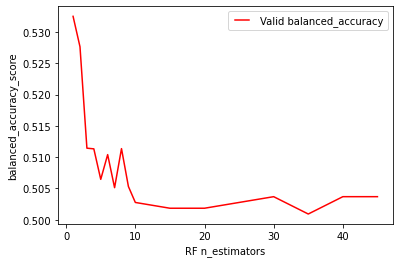

In [36]:
n_estimators = np.concatenate( (np.arange(1, 10, 1), np.arange(10, 50, 5) ))
test_results = []

for n in n_estimators:
    rforest = RandomForestClassifier(n_estimators = n, max_depth=5)
    rforest.fit(xtrain_final, ytrain_final)
    ypred = rforest.predict(xvalid_final)
    accuracy = balanced_accuracy_score(yvalid_final, ypred)
    test_results.append(accuracy)
    
line1, = plt.plot(n_estimators, test_results, 'r', label="Valid balanced_accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('balanced_accuracy_score')
plt.xlabel('RF n_estimators')
plt.show()

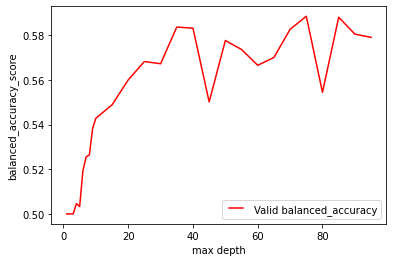

In [37]:
max_depths = np.concatenate( (np.arange(1, 10, 1), np.arange(10, 100, 5) ))
test_results = []

for max_depth in max_depths:
    rforest = RandomForestClassifier(n_estimators = 5, max_depth=max_depth)
    rforest.fit(xtrain_final, ytrain_final)
    ypred = rforest.predict(xvalid_final)
    accuracy = balanced_accuracy_score(yvalid_final, ypred)
    test_results.append(accuracy)
    
line1, = plt.plot(max_depths, test_results, 'r', label="Valid balanced_accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('balanced_accuracy_score')
plt.xlabel('max depth')
plt.show()

In [38]:
# Number of trees in random forest
n_estimators = np.concatenate( (np.arange(1, 10, 1), np.arange(10, 50, 5) ))

# Maximum number of levels in tree
max_depth = np.concatenate( (np.arange(1, 10, 1), np.arange(10, 50, 5) ))

# number of features at every split
max_features = ['auto', 'sqrt', 'log2']

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
class_weight = [None, 'balanced', 'balanced_subsample']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight
              }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42,)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10,
                               scoring='balanced_accuracy', cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(xtrain_cv, ytrain_cv)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.8s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 15, 20, 25, 30, 35, 40, 45]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 15, 20, 25, 30, 35, 40, 45])},
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [39]:
best_params = rf_random.best_params_
print(best_params)

{'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8, 'class_weight': 'balanced'}


In [40]:
rf_clf = RandomForestClassifier(**best_params)

rf_clf.fit(xtrain_final, ytrain_final)  # training

ypred = rf_clf.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.6767061306976706


In [41]:
best_pca_clf = RandomForestClassifier(**best_params)

best_pca_clf.fit(xtrain_pca[:, :best_pca_n_components], ytrain_final)  # training

best_pca_predictions = best_pca_clf.predict(pca_model.transform(xvalid_final)[:, :best_pca_n_components])
    
best_pca_score = balanced_accuracy_score(yvalid_final, best_pca_predictions)  # scoring
print("Best PCA Balanced accuracy score: {}".format(best_pca_score))

Best PCA Balanced accuracy score: 0.674839021117484


### Question 3: What is up-sampling? Why it may be worth a try for this problem?

By oversampling, we duplicate instances of the minority class.  
It might be an interesting idea in this case.  
In the original dataset, there is only less than 3000 positive samples, and more than 70 000 negative sample.

<img src="https://miro.medium.com/max/725/0*FeIp1t4uEcW5LmSM.png">

In [42]:
# check version number
! pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [43]:
#up-sampling training data 
os_smote = SMOTE(random_state=42)
columns = xtrain_final.columns

os_data_X, os_data_y = os_smote.fit_sample(xtrain_final, ytrain_final)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data

print("length of oversampled data is ",len(os_data_X))
print("Number of survivals in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of non survivals",len(os_data_y[os_data_y['y']==1]))
print("Proportion of survivals in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of non survivals in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  17866
Number of survivals in oversampled data 8933
Number of non survivals 8933
Proportion of survivals in oversampled data is  0.5
Proportion of non survivals in oversampled data is  0.5


In [44]:
rf_random_clf = RandomForestClassifier(**best_params)

rf_random_clf.fit(os_data_X, os_data_y.values.ravel())  # training

ypred = rf_random_clf.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.6411361386341137


## Linear Discriminant Analysis

In [45]:
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(os_data_X, os_data_y.values.ravel())

ypred = lda_clf.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print(" Balanced accuracy score: {}".format(score))

 Balanced accuracy score: 0.6829444203532944


In [46]:
#up-sampling and cross-validation to improve the accuracy of the model

In [47]:
#concatenate xtrain, and xvalid for cross-validation
X_cv = np.concatenate((xtrain_final, xvalid_final), axis = 0)
y_cv = np.concatenate((ytrain_final, yvalid_final))

In [48]:
#up-sampling training data 
os_smote = SMOTE()
columns = xtrain_final.columns

os_X, os_y = os_smote.fit_sample(X_cv, y_cv)
os_X = pd.DataFrame(data=os_X,columns=columns )
os_y= pd.DataFrame(data=os_y,columns=['y'])
# we can Check the numbers of our data

print("length of oversampled data is ",len(os_X))
print("Number of no subscription in oversampled data",len(os_y[os_y['y']==0]))
print("Number of subscription",len(os_y[os_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_y[os_y['y']==0])/len(os_X))
print("Proportion of subscription data in oversampled data is ",len(os_y[os_y['y']==1])/len(os_X))

length of oversampled data is  22376
Number of no subscription in oversampled data 11188
Number of subscription 11188
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [49]:
lda = LinearDiscriminantAnalysis()
lda.fit(os_X, os_y.values.ravel())

cv_results = cross_validate(lda, os_X, os_y.values.ravel(), cv=2, scoring='balanced_accuracy')
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_score']

In [50]:
print("Cross validation balanced accuracy: ")
print(cv_results['test_score'])
print("The average score of cross validation: ", cv_results['test_score'].mean())

Cross validation balanced accuracy: 
[0.77636754 0.79183053]
The average score of cross validation:  0.7840990346800143


In [51]:

ypred = lda.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print(" Balanced accuracy score: {}".format(score))

 Balanced accuracy score: 0.7623873966012387


## <a id="save"> V) Save Predictions</a>

* Use the following code to make predictions and save them as a ZIP file.
* Try to upload this ZIP file into the competition ("Participate > Submit/ View Results > Submit")
* Do your best to be **on top of the leaderboard!**

In [52]:
xtest_preprocess = preprocess(X_test)
predictions = lda.predict(xtest_preprocess)  # compute predictions (0 and 1)


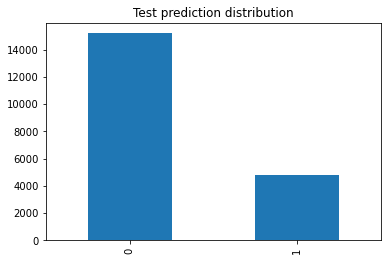

In [53]:
pd.Series(predictions).value_counts().plot.bar(title="Test prediction distribution")

In [54]:
predictions_file = "mimic_synthetic_test.csv"
pd.Series(predictions).to_csv(predictions_file, index=False, header=False)
print("Predictions saved.")

t = time.asctime().replace(" ", "_").replace(":", "-")
output_file = "./submissions/submission_" + t + ".zip"

# !zip test_submission.zip mimic_synthetic_test.csv # create a ZIP

with ZipFile(output_file, "w") as z:
    z.write(predictions_file)
print("The submission is ready: {}".format(output_file))

Predictions saved.
The submission is ready: ./submissions/submission_Mon_Dec__7_20-13-19_2020.zip


### Interesting to know!

The dataset doesn't contain actual medical data. We are not allowed to share with you such **confidential data** from critical care patients. To avoid that problem, we replaced the data by **artificial data**. 

In order to have credible data, we have generated them using a **Wasserstein GAN**.

For more information, here is a reference: <br />
Privacy Preserving Synthetic Health Data <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />
https://hal.inria.fr/hal-02160496/document